In [3]:
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import seaborn as sns
from itertools import cycle



In [4]:
# Verileri yükleme fonksiyonu
def load_images(folder_path):
    images = []
    labels = []

    for label in os.listdir(folder_path):
        label_folder = os.path.join(folder_path, label)
        if not os.path.isdir(label_folder):
            continue
        for file in os.listdir(label_folder):
            img_path = os.path.join(label_folder, file)
            try:
                img = Image.open(img_path).resize((102, 136))
                img = np.array(img)
                if img.shape == (136, 102, 3):
                    images.append(img)
                    labels.append(label)
            except:
                continue
    return np.array(images), np.array(labels)

# Veriyi yükle
X, y = load_images("dataset")



In [5]:
# Normalizasyon
X = X / 255.0

# Etiketleri sayısal hale getir
le = LabelEncoder()
y_encoded = le.fit_transform(y)
y_categorical = to_categorical(y_encoded, num_classes=3)



In [6]:
# Eğitim ve test verilerine ayır
X_train, X_test, y_train, y_test = train_test_split(X, y_categorical, test_size=0.2, random_state=42)



In [7]:
# Data Augmentation
datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True, # ***
    fill_mode='nearest'
)



In [8]:
# Model oluşturma
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(136, 102, 3)),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(3, activation='softmax')
])

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])



/home/seda-ozkaya/PycharmProjects/CNN_ShoeBootSandal_Classification/.venv/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  kernel_constraint=None,
E0000 00:00:1746427171.746708    8011 cuda_executor.cc:1228] INTERNAL: CUDA Runtime error: Failed call to cudaGetRuntimeVersion: Error loading CUDA libraries. GPU will not be used.: Error loading CUDA libraries. GPU will not be used.
W0000 00:00:1746427171.747556    8011 gpu_device.cc:2341] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [10]:
# Modeli eğitme
history = model.fit(
    datagen.flow(X_train, y_train, batch_size=32),
    epochs=15,
    validation_data=(X_test, y_test)
)



Epoch 1/15
375/375 ━━━━━━━━━━━━━━━━━━━━ 52s 139ms/step - accuracy: 0.7629 - loss: 0.5824 - val_accuracy: 0.8857 - val_loss: 0.3009
Epoch 2/15
375/375 ━━━━━━━━━━━━━━━━━━━━ 53s 141ms/step - accuracy: 0.8160 - loss: 0.4463 - val_accuracy: 0.9003 - val_loss: 0.2612
Epoch 3/15
375/375 ━━━━━━━━━━━━━━━━━━━━ 50s 132ms/step - accuracy: 0.8428 - loss: 0.3958 - val_accuracy: 0.9120 - val_loss: 0.2401
Epoch 4/15
375/375 ━━━━━━━━━━━━━━━━━━━━ 48s 127ms/step - accuracy: 0.8715 - loss: 0.3467 - val_accuracy: 0.9197 - val_loss: 0.2188
Epoch 5/15
375/375 ━━━━━━━━━━━━━━━━━━━━ 45s 120ms/step - accuracy: 0.8789 - loss: 0.3195 - val_accuracy: 0.9157 - val_loss: 0.2196
Epoch 6/15
375/375 ━━━━━━━━━━━━━━━━━━━━ 39s 104ms/step - accuracy: 0.8901 - loss: 0.3033 - val_accuracy: 0.9247 - val_loss: 0.1998
Epoch 7/15
375/375 ━━━━━━━━━━━━━━━━━━━━ 39s 103ms/step - accuracy: 0.8995 - loss: 0.2723 - val_accuracy: 0.9420 - val_loss: 0.1646
Epoch 8/15
375/375 ━━━━━━━━━━━━━━━━━━━━ 38s 101ms/step - accuracy: 0.9102 - loss: 0

In [11]:
,# Modeli değerlendirme
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)
print("\nTest Doğruluğu (Test Accuracy): %{:.2f}".format(test_acc * 100))




Test Doğruluğu (Test Accuracy): %96.53


94/94 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step


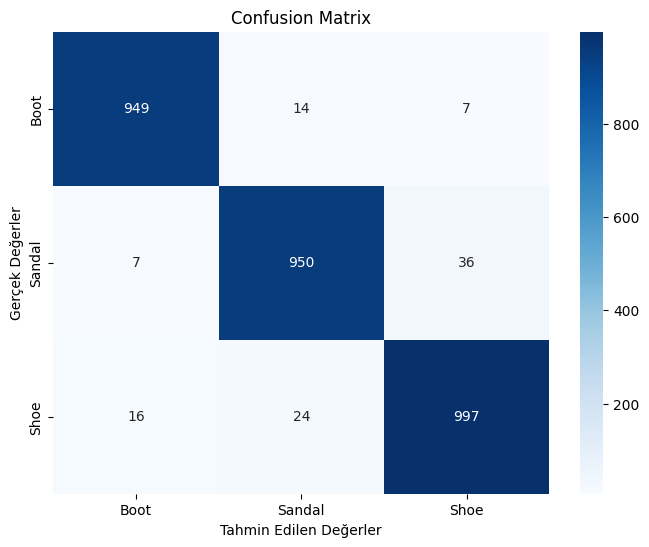


Classification Report:
              precision    recall  f1-score   support

        Boot       0.98      0.98      0.98       970
      Sandal       0.96      0.96      0.96       993
        Shoe       0.96      0.96      0.96      1037

    accuracy                           0.97      3000
   macro avg       0.97      0.97      0.97      3000
weighted avg       0.97      0.97      0.97      3000



In [12]:

# 1. Confusion Matrix
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

cm = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=le.classes_,
            yticklabels=le.classes_)
plt.title('Confusion Matrix')
plt.ylabel('Gerçek Değerler')
plt.xlabel('Tahmin Edilen Değerler')
plt.show()

# 2. Classification Report
print("\nClassification Report:")
print(classification_report(y_true, y_pred_classes, target_names=le.classes_))





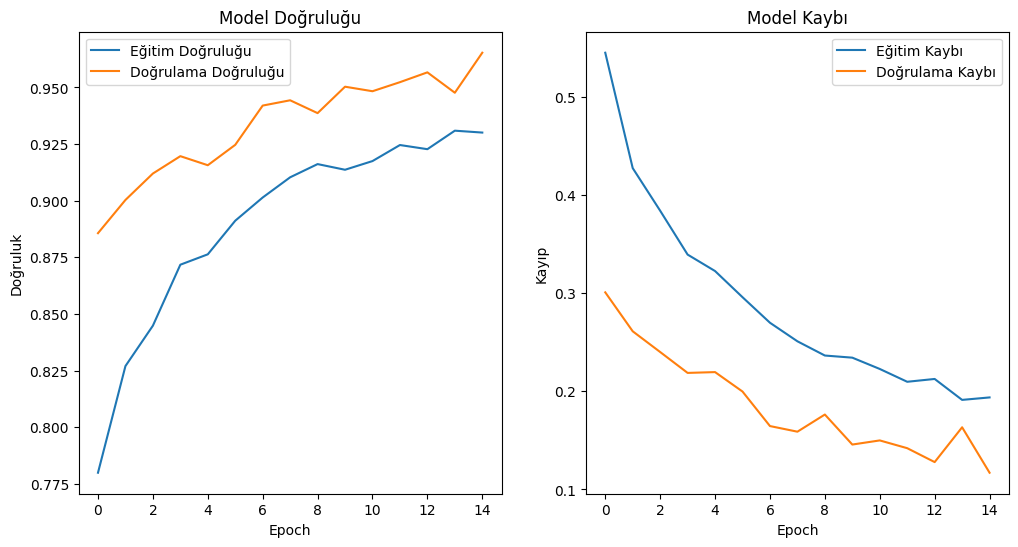

In [13]:
# 4. Loss Function Grafiği
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Eğitim Doğruluğu')
plt.plot(history.history['val_accuracy'], label='Doğrulama Doğruluğu')
plt.title('Model Doğruluğu')
plt.ylabel('Doğruluk')
plt.xlabel('Epoch')
plt.legend()



plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Eğitim Kaybı')
plt.plot(history.history['val_loss'], label='Doğrulama Kaybı')
plt.title('Model Kaybı')
plt.ylabel('Kayıp')
plt.xlabel('Epoch')
(plt.legend())

plt.show()



In [14]:
# Modeli kaydet
model.save("shoe_model_complete.h5")
print("Model başarıyla kaydedildi.")

Model başarıyla kaydedildi.
